# Forecast skill

Showcasing model evaluation for forecasting when using modelskill

In [339]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import modelskill as ms

In [340]:
sns.set_palette("Set1")

In this notebook, we depart from a dataframe containing matched results from two models. To see how that dataframe is created, consider visiting the [data wrangling notebook](../notebooks/Forecast_data_wrangling.ipynb).


In [341]:
def path_to_file(filename):
    return f"../tests/testdata/forecast_skill/{filename}"

matched_model_results = pd.read_csv(path_to_file("matched_model_results.csv"), parse_dates=True, index_col=0)
matched_model_results.round(2).head()

,lead_time,model_1,model_2,observation
date,,,,
2023-01-07,1,13804.10,12663.04,14319.96
2023-01-07,2,13302.96,12898.16,14319.96
2023-01-07,3,13388.44,13505.24,14319.96
2023-01-07,4,13014.56,13444.72,14319.96
2023-01-07,5,12845.50,13086.09,14319.96


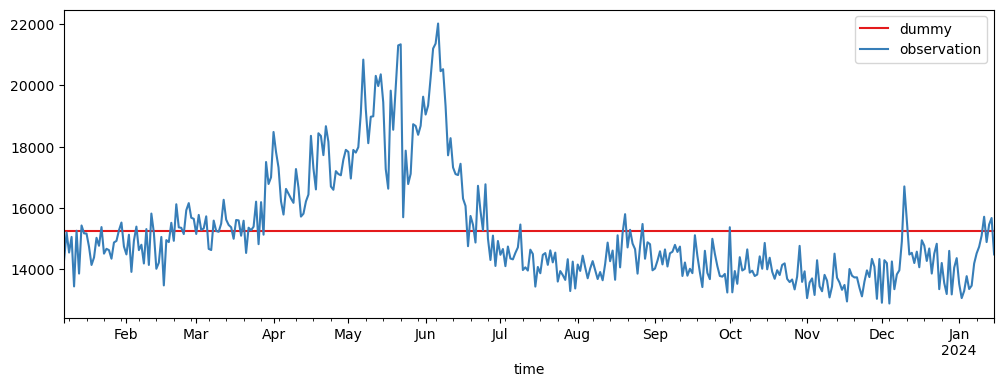

In [342]:
observations = matched_model_results["observation"].drop_duplicates().to_frame()

obs = ms.PointObservation(observations)
mr = ms.DummyModelResult(strategy='mean')
pmr = mr.extract(obs).to_dataframe()

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pmr.merge(observations, on="time").plot(ax=ax)
plt.show()


In [343]:
pmr.index.name = "date"
matched_model_results = matched_model_results.merge(pmr, on="date", how="inner")

In [344]:
cmp = ms.from_matched(matched_model_results, mod_items=["model_1", "model_2", "dummy"], aux_items=["lead_time"], obs_item="observation")

metrics = ["bias", "rmse", "mae", "mape"]
sk = cmp.skill(by=["model", "lead_time"], metrics=metrics).sort_index()
sk.round(2).style()

## Plotting

In [350]:
def prepare_skill_table_for_plot(sk):
    skill_for_plot = sk.to_dataframe().reset_index().drop(columns=["observation", "n"])
    baseline = pd.DataFrame(
        {
            "model": ["dummy", "model_1", "model_2"],
            "lead_time": [0, 0, 0],
        }
    )
    # We add a line of zeros for viz purposes
    for metric in metrics:
        baseline[metric] = 0

    return pd.concat([skill_for_plot, baseline]).sort_values(by=["model", "lead_time"])

def plot_skill_by_lead_time(df, metric, ax):
    sns.lineplot(
        data=df,
        x="lead_time",
        y=metric,
        hue="model",
        ax=ax,
    )
    fig.suptitle("Skill by lead time")

    ax.set_xlabel("Lead time [days]", fontsize=14)
    ax.set_ylabel("MAPE [%]", fontsize=14)
    ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.28, 0.7)),
    ax.tick_params(axis="both", which="major", labelsize=14)

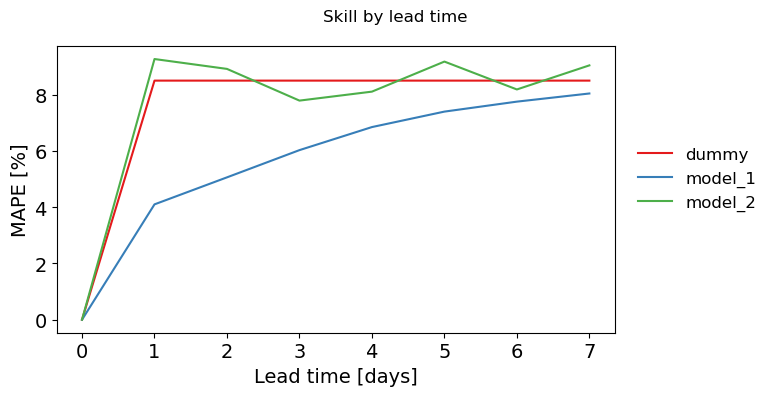

In [351]:
metric = "mape"
skill_for_plot = prepare_skill_table_for_plot(sk)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_skill_by_lead_time(skill_for_plot, metric, ax)
plt.tight_layout()
plt.show()

The previous plot only shows one value for each lead time; however, it can be interesting see evaluate how the errors are distributed. The following section shows how to plot how the distribution of error changes as the lead time grows.

### Distribution per lead time

The skilltable returns one value per category, e.g. (model_1, lead_time=2) and we would like to have a collection of points to draw the distribution. For this reason, we cannot generate the plot from the skill. Instead, we use the raw dataframe that contains all observations per model and lead_time.

In [252]:
df1 = pd.melt(matched_model_results.reset_index(), id_vars=["time", "lead_time", "observation"], var_name="model")

df1["error"] = df1["observation"] - df1["value"]
df1["absolute_error"] = abs(df1["error"])
df1["percentage_error"] = 100 * df1["absolute_error"] / df1["observation"]

ylabel_dict = {"error": "Error", "absolute_error": "Absolute error", "percentage_error": "Percentage error [%]"}
errorcol = "percentage_error"

models = df1["model"].unique().tolist()

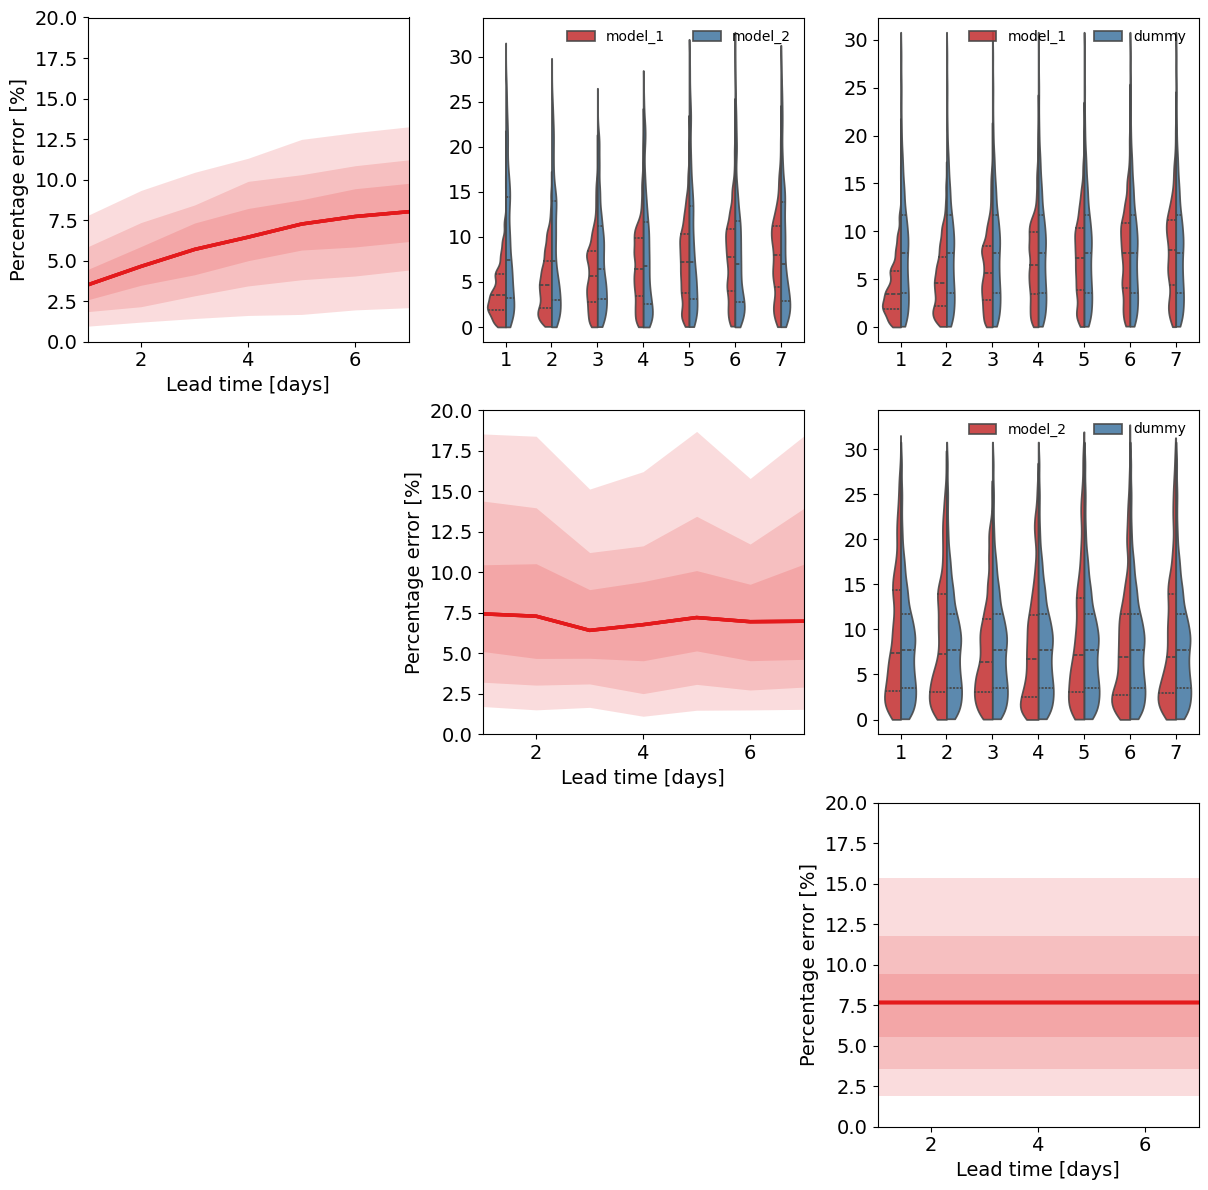

In [360]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

def plot_skill_quantile_by_leadtime(df, ax):
    for interval in [25, 50, 75]:
        sns.lineplot(
            df,
            x="lead_time",
            y="percentage_error",
            estimator="median",
            errorbar=("pi", interval),
            hue="model",
            ax=ax,
            linewidth=2.5,
            err_kws=dict(linewidth=0, alpha=0.15)
        )
    
    ax.legend([],[], frameon=False)
    ax.set_xlabel("Lead time [days]", fontsize=14)
    ax.set_ylabel(ylabel_dict[errorcol], fontsize=14)

def plot_model_comparison_with_violinplot(df, ax):
    sns.violinplot(
        data=df,
        x="lead_time",
        y=errorcol,
        hue="model",
        split=True,
        gap=0,
        inner="quarts",
        ax=ax,
        alpha=0.9,
        saturation=0.7,
        bw_adjust=0.6,
        common_norm=True,
        density_norm="area",
        cut=0,
    )
    ax.legend(frameon=False, ncols = 2)
    ax.set_xlabel("")
    ax.set_ylabel("")


for i, model_i in enumerate(models):

    df_ii = df1.loc[df1["model"] == model_i, :].copy()

    plot_skill_quantile_by_leadtime(df_ii, axes[i, i])
    axes[i, i].tick_params(axis="both", which="major", labelsize=14)
    axes[i, i].set_xlim(1, 7)
    axes[i, i].set_ylim(0, 20)

    other_models = [m for m in models if m != model_i]
    for model_j in other_models:
        j = models.index(model_j)
        if j > i:
            comb = (model_i, model_j)
            df_ij = df1.loc[df1["model"].isin(comb), :].copy()
            plot_model_comparison_with_violinplot(df_ij, axes[i, j])
        else:
            axes[i, j].set_axis_off()
    
        axes[i, j].tick_params(axis="both", which="major", labelsize=14)


plt.tight_layout()
plt.show()

# Focusing on period

In [349]:
july_skill = cmp.where(cmp.data.time.dt.month == 7).skill(by=["model", "lead_time"], metrics=metrics).sort_index()

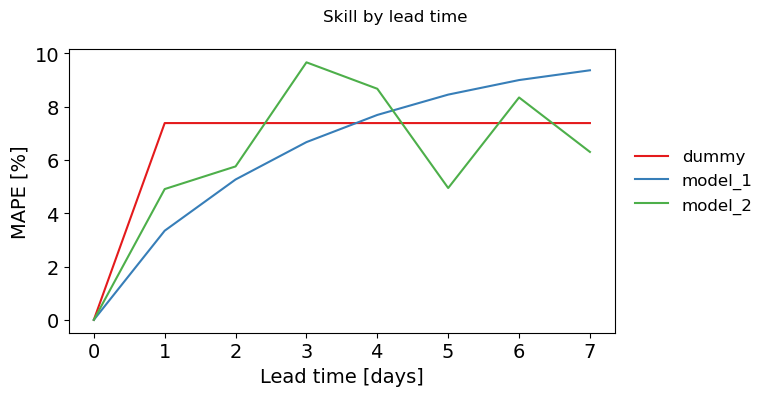

In [352]:
july_skill_for_plot = prepare_skill_table_for_plot(july_skill)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_skill_by_lead_time(july_skill_for_plot, metric, ax)
plt.tight_layout()
plt.show()

### Appendix: Building a Skill object using `ComparerCollection`

In [6]:
# observations = pd.read_csv(path_to_file("observations.csv"), parse_dates=True)
# forecast_model_1 = pd.read_csv(path_to_file("forecast_model_1.csv"), parse_dates=True, index_col=0)
# forecast_model_2 = pd.read_csv(path_to_file("forecast_model_2.csv"), parse_dates=True, index_col=0)


# obs = ms.PointObservation(observations)
# ms.match(obs=obs, mod=ms.PointModelResult(results_model_1[1], name="model_1_1"))

# list_of_comparers_1 = [ms.match(obs=obs, mod=ms.PointModelResult(results_model_1[i], name=f"model_1.{i}")) for i in range(0, 7 + 1)]
# list_of_comparers_2 = [ms.match(obs=obs, mod=ms.PointModelResult(results_model_2[i], name=f"model_2.{i}")) for i in range(0, 7 + 1)]
# cc = ms.ComparerCollection(list_of_comparers_1 + list_of_comparers_2)

# skill_A = cc.skill().to_dataframe()

# def get_model_name(x, sep="."):
#     return x[0].split(sep)[0]

# def get_lead_time(x, sep="."):
#     return x[0].split(sep)[1]

# skill_A["model"] = skill_A.index.to_series().apply(get_model_name)
# skill_A["lead_time"] = skill_A.index.to_series().apply(get_lead_time)

# skill_A.reset_index(drop=True, inplace=True)
# index_tuples = list(skill_A[["model", "lead_time"]].itertuples(index=False, name=None))
# skill_A.index = pd.MultiIndex.from_tuples([model_j for model_j in index_tuples], names=['model', 'lead_time'])
# skill_A = skill_A.sort_index().drop(columns=["model", "lead_time"])